In [1]:
import os
import cv2
import imutils
from tqdm import tqdm
import numpy as np

from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.engine import Model

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

# Progress display

In [58]:
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import time
# for i in tqdm_notebook(range(10), desc = 'Progress using tqdm_notebook()'):
# # for i in tqdm(range(10), desc = 'Progress using tqdm_notebook()'):
#     time.sleep(0.5)
    
with tqdm(total=100, desc = 'Progress using tqdm_notebook()') as pbar:
    for i in range(10):
        time.sleep(0.1)
        pbar.update(10)
pbar.close()

Progress using tqdm_notebook(): 100%|████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.78it/s]


# Get length and number of frames 

In [3]:
def get_info_video(filename=''):
    video = cv2.VideoCapture(filename)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = int(frame_count/fps)
    video.release()
    return fps, frame_count, duration

In [4]:
get_info_video('VIDEO/1.NGUYENPHUTRONG/1.mp4')

(30.0, 1024.0, 34)

# Get images from video

### get all frame

In [9]:
video = cv2.VideoCapture('VIDEO/1.NGUYENPHUTRONG/1.mp4')
count = 0
while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        count+= 1
#         print(count)
#     plt.imshow(frame)
#     plt.show()
    else:
        break
video.release()
print(count)

1024


### get frame each second

In [4]:
def get_frame_from_video_by_second(video_path='', extract_info_from_frame=lambda x:x):
    video = cv2.VideoCapture(video_path)
    
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = int(frame_count/fps)
    
    frame_count = 0

    with tqdm(total=duration, desc = 'Process video') as pbar:
        while(video.isOpened()):
            ret, frame = video.read()
            if ret == True:
                if frame_count % fps == 0:
                    # do somethings
                    extract_info_from_frame(frame)
                    pbar.update(1)
                frame_count += 1
            else:
                break 

    pbar.close()
    video.release()
    
    ret_dict = {
        'file_name': video_path,
        'duration': duration,
        'fps': fps
    }
    return ret_dict

In [57]:
video_path = 'VIDEO/1.NGUYENPHUTRONG/1.mp4'
get_frame_from_video_by_second(video_path)

Process video: 35it [00:01, 33.65it/s]                                                                                 


{'file_name': 'VIDEO/1.NGUYENPHUTRONG/1.mp4', 'duration': 34, 'fps': 30.0}

# Detect face

### Using cv2.dnn

In [115]:
class face_detector_res(object):
    def __init__(self, proto_path="model/deploy.prototxt", model_path="model/res10_300x300_ssd_iter_140000.caffemodel"):
        self.net = cv2.dnn.readNetFromCaffe(proto_path, model_path)

    def detect(self, frame):
        frame = imutils.resize(frame, width=400)
        return_faces = []
        (H, W) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (W, H), (104.0, 177.0, 123.0))
        self.net.setInput(blob)
        detections = self.net.forward()
        for i in range(0, detections.shape[2]):
            if detections[0, 0, i, 2] > 0.9:
                box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
                (startX, startY, endX, endY) = box.astype("int")
                return_faces.append(frame[startY:endY, startX:endX])

        return return_faces

In [116]:
face_detector = face_detector_res("model/deploy.prototxt", "model/res10_300x300_ssd_iter_140000.caffemodel")

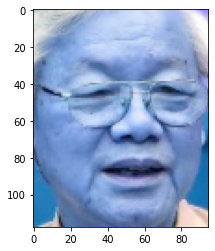

In [74]:
frame = cv2.imread("IMAGE/1.NGUYENPHUTRONG/13.webp")
return_faces = face_detector.detect(frame)
face0 = return_faces[0]
plt.imshow(face0)
# cv2.imwrite("test.jpg", face0)

In [23]:
frame = cv2.imread("IMAGE/1.NGUYENPHUTRONG/1.jpeg")
return_faces = face_detector.detect(frame)
face1 = return_faces[0]
plt.imshow(face1)
# cv2.imwrite("test.jpg", face1)

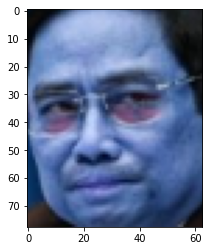

In [76]:
frame = cv2.imread("IMAGE/3.PHAMMINHCHINH/3.jpeg")
return_faces = face_detector.detect(frame)
face2 = return_faces[0]
plt.imshow(face2)
# cv2.imwrite("test.jpg", face1)

2


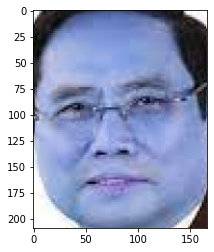

In [77]:
frame = cv2.imread("IMAGE/3.PHAMMINHCHINH/1.jpeg")
return_faces = face_detector.detect(frame)
face2 = return_faces[1]  # TODO: check
print(len(return_faces))
plt.imshow(face2)
# cv2.imwrite("test.jpg", face1)

### Using torch

In [10]:
from facenet_pytorch import MTCNN
import torch

In [11]:
class face_detector_torch(object):
    def __init__(self):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.mtcnn = MTCNN(keep_all=True)

    def detect(self, frame):
        return_faces = []
        frame = imutils.resize(frame, width=400)
        boxes, _ = self.mtcnn.detect(frame)
        if boxes is not None:
            for box in boxes:
                (startX, startY, endX, endY) = box.astype("int")
                return_faces.append(frame[startY:endY, startX:endX])

        return return_faces

In [119]:
face_detector = face_detector_torch()

1


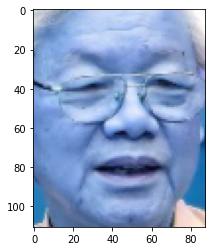

In [107]:
frame = cv2.imread("IMAGE/1.NGUYENPHUTRONG/13.webp")
return_faces = face_detector.detect(frame)
print(len(return_faces))
face0 = return_faces[0]
plt.imshow(face0)

1


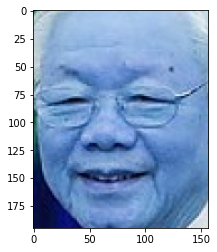

In [108]:
frame = cv2.imread("IMAGE/1.NGUYENPHUTRONG/1.jpeg")
return_faces = face_detector.detect(frame)
print(len(return_faces))
face1 = return_faces[0]
plt.imshow(face1)

1


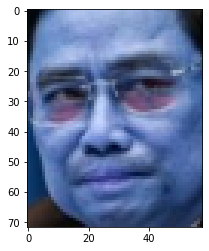

In [109]:
frame = cv2.imread("IMAGE/3.PHAMMINHCHINH/3.jpeg")
return_faces = face_detector.detect(frame)
print(len(return_faces))
face2 = return_faces[0]
plt.imshow(face2)

1


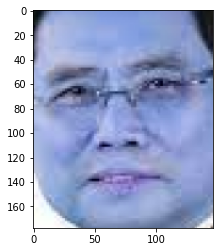

In [110]:
frame = cv2.imread("IMAGE/3.PHAMMINHCHINH/1.jpeg")
return_faces = face_detector.detect(frame)
print(len(return_faces))
face3 = return_faces[0]
plt.imshow(face3)

# Get embeding vector of face

In [7]:
class similarity_face(object):
    def __init__(self, layer="fc7"):
        layer_name = layer 
        vgg_model = VGGFace() 
        out = vgg_model.get_layer(layer_name).output
        self.vgg_model_new = Model(vgg_model.input, out)

    def get_embedding_vector(self, frame):
        try:
            resized = cv2.resize(frame, (224, 224))
            x = image.img_to_array(resized)
            x = np.expand_dims(x, axis=0)
            x = utils.preprocess_input(x, version=2) 
            preds = self.vgg_model_new.predict(x)
            return preds
        except Exception as e:
            print(e)
            return np.zeros((1, 4096))

In [8]:
vggface_net = similarity_face()

In [220]:
embed0 = vggface_net.get_embedding_vector(face0)
embed1 = vggface_net.get_embedding_vector(face1)
embed2 = vggface_net.get_embedding_vector(face2)
embed3 = vggface_net.get_embedding_vector(face3)

In [221]:
cosine_similarity(embed0, embed1)[0][0]

0.95926166

In [214]:
cosine_similarity(embed0, embed2)[0][0]

0.7698175

In [215]:
cosine_similarity(embed0, embed3)[0][0]

0.76439464

In [216]:
cosine_similarity(embed1, embed2)[0][0]

0.7893806

In [217]:
cosine_similarity(embed1, embed3)[0][0]

0.7884842

In [218]:
cosine_similarity(embed2, embed3)[0][0]

0.9277962

# Calculate cosine

In [8]:
from numpy import dot
from numpy.linalg import norm

# p1 = mat[:,-1].dot(mat[:,:-1])
# p2 = norm(mat[:,:-1],axis=0)*norm(mat[:,-1])
# out1 = p1/p2

def calculate_cosine_similarity(matrix, vector): # matrix:(n, 4096), vector: (1, 4096)
    p1 = dot(matrix, vector.reshape(-1,1))
    p2 = norm(matrix, axis=1)*norm(vector)
    return p1/p2.reshape(-1,1)

## Extract face embedding vectors and save to npy file

In [9]:
face_detector = face_detector_torch()
vggface_net = similarity_face()

In [36]:
os.makedirs('face_embedding', exist_ok=True)
person_dir = os.listdir('IMAGE')

In [37]:
for name in tqdm(person_dir):
    image_lst = os.listdir('IMAGE' + '/' + name)
    image_path_lst = map(lambda x: f'IMAGE/{name}/{x}', image_lst)
    def extract_face_embed_vector(image_path):
        frame = cv2.imread(image_path)
        return_faces = face_detector.detect(frame)
        return vggface_net.get_embedding_vector(return_faces[0])[0]
        
    face_embed_vector_lst = map(extract_face_embed_vector, image_path_lst)
    
    face_embed_matrix = np.stack(face_embed_vector_lst, axis=0)
    changed_name = name.replace('.', '_')
    np.save(f'face_embedding/{changed_name}.npy' , face_embed_matrix)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/it]


# Load face embeding matrix

In [9]:
embed_matrix_dir = os.listdir('face_embedding')

In [10]:
embed_matrix_dict = {}
for matrix_path in embed_matrix_dir:
    embedding_matrix = np.load('face_embedding/' + matrix_path)
    embed_matrix_dict[matrix_path[:-4]] = embedding_matrix

In [11]:
embed_matrix_dict

{'10_TRANHONGHA': array([[-13.115116  , -29.125893  , -25.15794   , ..., -10.987301  ,
         -37.788322  , -30.188868  ],
        [-19.437138  , -25.370663  , -24.974873  , ..., -10.704909  ,
         -29.481619  , -24.634418  ],
        [-35.558773  , -34.630238  , -32.16846   , ..., -16.168812  ,
         -40.1897    , -43.056656  ],
        ...,
        [-25.718973  , -18.281403  , -21.993412  , ...,   0.573639  ,
         -29.938873  , -14.076156  ],
        [-25.817701  , -24.864996  , -34.031532  , ...,  -0.38250917,
         -36.3617    , -19.99627   ],
        [-20.236643  , -14.214374  , -17.996706  , ..., -13.824411  ,
         -27.449484  , -22.10077   ]], dtype=float32),
 '1_NGUYENPHUTRONG': array([[-21.219446 , -22.465107 , -33.440903 , ...,  -7.0643816,
         -30.336834 , -32.246418 ],
        [-15.799755 ,  -3.4780378, -10.191367 , ...,  -3.3781772,
         -14.809083 , -13.581331 ],
        [ -7.9909196,  -1.7594461, -19.807055 , ...,   4.2734365,
         -21.88

# Search face similarity

In [9]:
class face_similarity_seacher(similarity_face):
    def __init__(self):
        similarity_face.__init__(self)
        self.embed_matrix_dict = {}
    
    def load_embed_matrix_dict(self, embeding_matrix_folder='face_embedding'):
        embed_matrix_dir = os.listdir('face_embedding')
        for matrix_path in embed_matrix_dir:
            embedding_matrix = np.load('face_embedding/' + matrix_path)
            self.embed_matrix_dict[matrix_path[:-4]] = embedding_matrix
            
    @staticmethod
    def calculate_cosine_similarity(matrix, vector): # matrix:(n, 4096), vector: (1, 4096)
        p1 = dot(matrix, vector.reshape(-1,1))
        p2 = norm(matrix, axis=1)*norm(vector)
        return p1/p2.reshape(-1,1)
    
    def seach_similarity_face(self, face_frame, thresh_hold = 0.9):
        embed_vector = self.get_embedding_vector(face_frame)
        ret_val = None
        for name, embedding_matrix in self.embed_matrix_dict.items():
            max_similarity_score = calculate_cosine_similarity(embedding_matrix, embed_vector).max()
            if max_similarity_score > thresh_hold:
                ret_val = (name, max_similarity_score)
                break
        return ret_val

# Tesing

In [12]:
face_detector = face_detector_torch()
face_searcher = face_similarity_seacher()
face_searcher.load_embed_matrix_dict()
def search_face(frame):
    ret_lst = []
    return_faces = face_detector.detect(frame)
    for face_frame in return_faces:
        ret_lst.append(face_searcher.seach_similarity_face(face_frame, thresh_hold = 0.95))
    return ret_lst

In [13]:
video_path = 'VIDEO/10.TRANHONGHA/4.mp4'
video = cv2.VideoCapture(video_path)
    
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
duration = int(frame_count/fps)

ret_dict = {
        'file_name': video_path,
        'duration': duration,
        'fps': fps,
        'face_lst': []
    }
frame_count = 0

while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        if frame_count % fps == 0:
            # do somethings
            info = search_face(frame)
            ret_dict['face_lst'].append(info)
        frame_count += 1
    else:
        break 

video.release()

D:\Program Files\anaconda3\envs\python_env\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\LEGION\AppData\Local\Temp\ipykernel_15560\1903312081.py:11: RuntimeWarning: invalid value encountered in true_divide
  return p1/p2.reshape(-1,1)


OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\ope

In [16]:
for i in ret_dict['face_lst']:
    print(i)

[None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[('10_TRANHONGHA', 0.95179075)]
[('10_TRANHONGHA', 0